In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt

2024-04-25 04:52:31.929364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 04:52:31.929460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 04:52:32.034626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_dir = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"
normal_dir = os.path.join(dataset_dir, "Normal")
tuberculosis_dir = os.path.join(dataset_dir, "Tuberculosis")

In [4]:
def preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")    # Convert grayscale to RGB
            image = image.resize((256, 256))  # Resize images to 256x256 pixels
            image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(label)
    return images, labels

In [5]:
# Load and preprocess normal images
normal_images, normal_labels = preprocess_images(normal_dir, label=0)
# Load and preprocess tuberculosis images
tuberculosis_images, tuberculosis_labels = preprocess_images(tuberculosis_dir, label=1)

In [6]:
# Combine normal and tuberculosis images
images = normal_images + tuberculosis_images
labels = normal_labels + tuberculosis_labels

In [7]:
images = np.array(images)
labels = np.array(labels)

In [8]:
df1=pd.read_csv('/kaggle/input/tuberculosis-chest-xrays-shenzhen/shenzhen_metadata.csv')
base_path='/kaggle/input/tuberculosis-chest-xrays-shenzhen/images/images/'
df1['equalized_filename'] = df1['study_id'].apply(lambda x: base_path+x)
df2=pd.read_csv('/kaggle/input/tuberculosis-chest-xrays-montgomery/montgomery_metadata.csv')
base_path='/kaggle/input/tuberculosis-chest-xrays-montgomery/images/images/'
df2['equalized_filename'] = df2['study_id'].apply(lambda x: base_path+x)
df=pd.concat([df1, df2], ignore_index=True)
df['target']=df['findings'].apply(lambda x:0 if x=='normal' else 1)
df['target'] = df['target'].astype(str)
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
def preprocess_images_cxr(image_dir):
    images = []
    for filename in image_dir:
        image = Image.open(filename)
        image = image.convert("RGB")    # Convert grayscale to RGB
        image = image.resize((256, 256))  # Resize images to 256x256 pixels
        image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]
        images.append(image)
    return images

In [10]:
tuberculosis_images_new = preprocess_images_cxr(df['equalized_filename'])
tuberculosis_labels_new= df['target'].values

In [11]:
new_images=np.array(tuberculosis_images_new)
new_labels=np.array(tuberculosis_labels_new)

In [12]:
images= np.concatenate((images, new_images), axis=0)
images.shape

(5000, 256, 256, 3)

In [13]:
labels=np.concatenate((labels,new_labels),axis=0)
labels.shape

(5000,)

In [14]:
labels=labels.astype(int)

In [15]:
images, new_images, labels, new_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input

from tensorflow.keras.optimizers import Adam

In [17]:
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [18]:
history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:14:26 36s/step - accuracy: 0.0938 - loss: 1.0155

I0000 00:00:1714021126.542316     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714021126.607252     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8245 - loss: 0.3968

W0000 00:00:1714021148.970495     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 312ms/step - accuracy: 0.8249 - loss: 0.3959 - val_accuracy: 0.9320 - val_loss: 0.1995
Epoch 2/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.9062 - loss: 0.1733

W0000 00:00:1714021165.329562     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.9269 - loss: 0.1740 - val_accuracy: 0.9320 - val_loss: 0.1654
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.9444 - loss: 0.1459 - val_accuracy: 0.9370 - val_loss: 0.1520
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9581 - loss: 0.1157 - val_accuracy: 0.9530 - val_loss: 0.1203
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9499 - loss: 0.1172 - val_accuracy: 0.9580 - val_loss: 0.1132
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.9582 - loss: 0.1090 - val_accuracy: 0.9440 - val_loss: 0.1335
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9630 - loss: 0.0991 - val_accuracy: 0.8890 - val_loss: 0.2596
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9566 - loss: 0.1100 - val_accuracy: 0.9420 - val_loss: 0.1347
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9761 - loss: 0.0637 - val

In [19]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9590 - loss: 0.1058
Test Loss: 0.09921487420797348
Test Accuracy: 0.9629999995231628


In [20]:
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

W0000 00:00:1714021306.923687     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step


W0000 00:00:1714021318.931371     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [21]:
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       781
           1       0.90      0.94      0.92       219

    accuracy                           0.96      1000
   macro avg       0.94      0.95      0.95      1000
weighted avg       0.96      0.96      0.96      1000

Confusion Matrix:
[[757  24]
 [ 13 206]]


In [22]:
import seaborn as sns

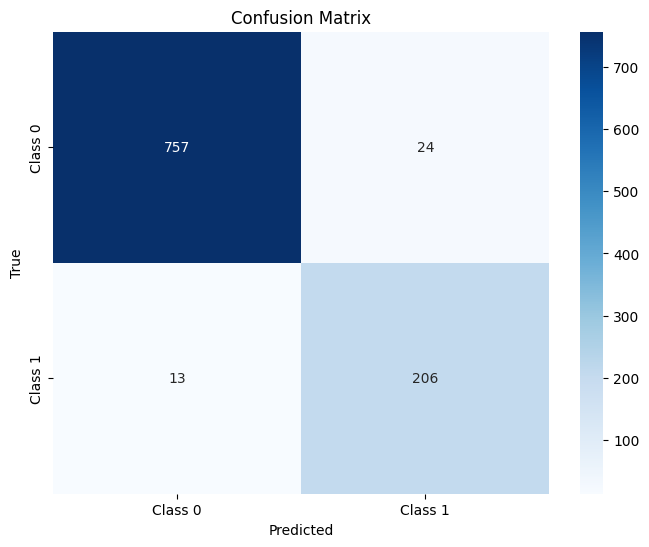

In [23]:
class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# def histogram_equalization(image_path):
#     # Read the image in grayscale
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
#     # Apply histogram equalization
#     equalized_img = cv2.equalizeHist(img)
    
#     # Display the original and equalized images
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(img, cmap='gray')
#     plt.title('Original Image')
    
#     plt.subplot(1, 2, 2)
#     plt.imshow(equalized_img, cmap='gray')
#     plt.title('Equalized Image')
    
#     plt.show()